<a href="https://colab.research.google.com/github/ilyatro/Funny-models-and-scripts/blob/master/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment — Link analysis and structure properties

In [ ]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import requests
import networkx as nx

### Task 1. PageRank algorithm (0 points)

Implement PageRank algorithm. A function `page_rank` takes a graph `G`, transition coefficient `alpha` and number of iterations `k`. The function returns np.array of PageRank scores.


In [ ]:
'''Do not touch the cell'''
def page_rank(G, alpha, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = teleportation_vector(A)
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return rank / rank.sum()

Write a function `transition_matrix` that takes a np.array with an adjacency matrix `A` and returns a np.array with a transition matrix where an entry $p_{ij}$ equals to probability of going to $j$ if we are in $i$.

In [ ]:
def transition_matrix(A):
    row_sums = A.sum(axis=1, keepdims=True)
    return A / np.where(row_sums > 0, row_sums, 1)



In [ ]:
A = [[0, 1, 1], # probability P(0→1) = P(0→2) = 1/2
     [0, 0, 1], # probability P(1→2) = 1
     [1, 0, 0]] # probability P(2→0) = 1
A = np.array(A)
tran_sum = transition_matrix(A).sum(axis=1)
assert tran_sum[0] == tran_sum[1] == tran_sum[2] == 1

Write a function `teleportation_vector` that takes a np.array with an adjacency matrix `A` and returns a np.array with a teleportation vector where $p_i$ is a probability to teleport to a node $i$ (by default it is a uniform distribution).

In [ ]:
def teleportation_vector(A):
    return np.ones(A.shape[0]) / A.shape[0]

In [ ]:
assert teleportation_vector(A).sum() == 1

Write a function `update_rank`. Check the function `page_rank` to understand parameters. An iterative process is defined as

$$\begin{matrix}
r &=& \text{transition} &+& \text{teleportation}\\
r &=& \alpha P^T r &+& (1 - \alpha)v
\end{matrix}
$$

where $P$ is a transition matrix, $v$ is a teleportation vector.

In [ ]:
def update_rank(rank, P, v, alpha):
    # return alpha * P.T @ rank + (1 - alpha) * v
    return alpha * P.T.dot(rank) + (1 - alpha) * v

In [ ]:
G = nx.path_graph(6, create_using=nx.DiGraph)
pr = page_rank(G, 0.9, 100)
assert np.all(pr[1:] - pr[:-1] > 0)

Let us draw the graph where node size depends on PageRank.

In [ ]:
pr

array([0.05608622, 0.10656383, 0.15199367, 0.19288053, 0.2296787 ,
       0.26279705])

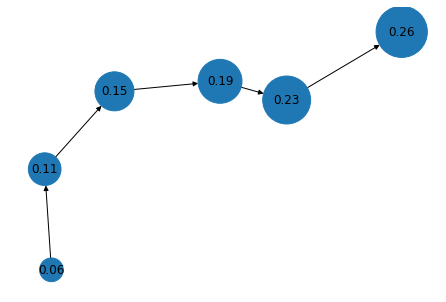

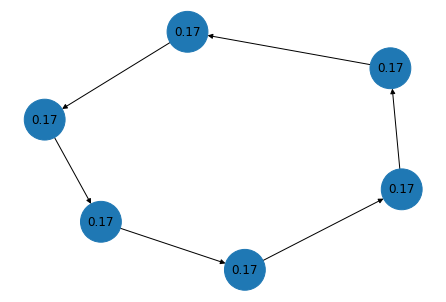

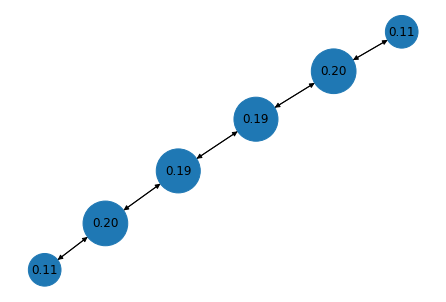

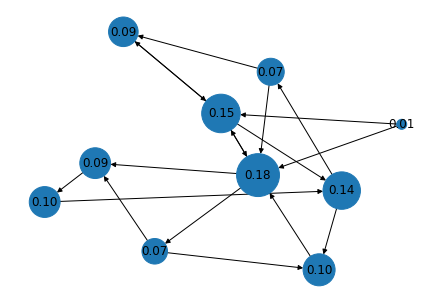

In [ ]:
graphs = [
    nx.path_graph(6, create_using=nx.DiGraph),
    nx.cycle_graph(6, create_using=nx.DiGraph),
    nx.DiGraph(nx.path_graph(6)),
    nx.erdos_renyi_graph(10, 0.2, directed=True)
]
for G in graphs:
    pr = page_rank(G, 0.9, 100)
    nx.draw(
        G,
        with_labels=True,
        node_size=(pr * 1e4),
        labels={node: f'{rank:.2f}' for node, rank in enumerate(pr)}
    )
    plt.show()

### Task 2. Personalized PageRank (0 points)

Personalized PageRank uses a teleportation vector as personal preferences, so that an important node has high probability to jump into it. Personalized PageRank can be considered as a simple recommender system. Consider a dataset of links between some famous painters on Wikipedia. Common PageRank gives us following ranks.

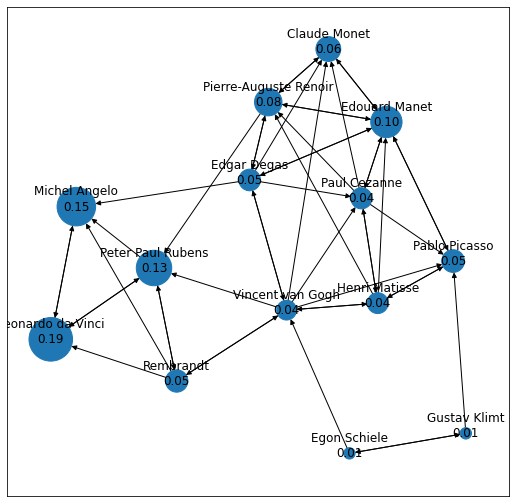

In [ ]:
def plot_painters(G, pr):
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize=(9, 9))
    nx.draw_networkx(
        G, 
        pos, 
        node_size=(pr * 1e4), 
        labels={node: f'{rank:.2f}' for node, rank in enumerate(pr)})
    nx.draw_networkx_labels(
        G, 
        pos={node: pos[node] + [0, 0.05] for node in pos}, 
        labels=nx.get_node_attributes(G, 'name')
    )

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/painters_graph.gml'
open('painters_graph.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('painters_graph.gml')
G = nx.convert_node_labels_to_integers(G)
pr = np.array([rank for node, rank in nx.pagerank(G, alpha=0.9).items()])
plot_painters(G, pr)
plt.show()

Now let us calculate personalized PageRank based on user's preferences. Construct a teleportation vector so that painters a user likes are proportional to ones and others are zeros.

Write a function `personalized_pr` that takes an argument of common PageRank and a list `pref` that contains names of painters that user likes. The function returns personalized PageRank.

In [ ]:
def personalized_pr(G, alpha, pref, k):
    A = nx.to_numpy_array(G)
    P = transition_matrix(A)
    v = np.zeros(len(G))
    for p in pref:
        for node in G.nodes:
            if p == G.nodes[node]['name']:
                v[node] = 1
    v = v / v.sum()
    rank = np.ones(A.shape[0]) / A.shape[0]
    for _ in range(k):
        rank = update_rank(rank, P, v, alpha)
    return rank / rank.sum()

In [ ]:
pref = ['Pablo Picasso', 'Edgar Degas']
pr1 = personalized_pr(G, alpha=0.9, pref=pref, k=100)
pref = ['Edgar Degas']
pr2 = personalized_pr(G, alpha=0.9, pref=pref, k=100)
assert np.isclose(pr1.sum(), 1) and np.isclose(pr2.sum(), 1)
assert pr1[0] > pr2[0]
assert pr1[7] < pr2[7]

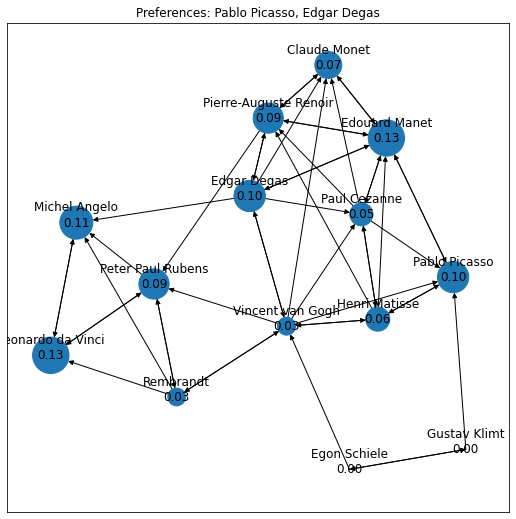

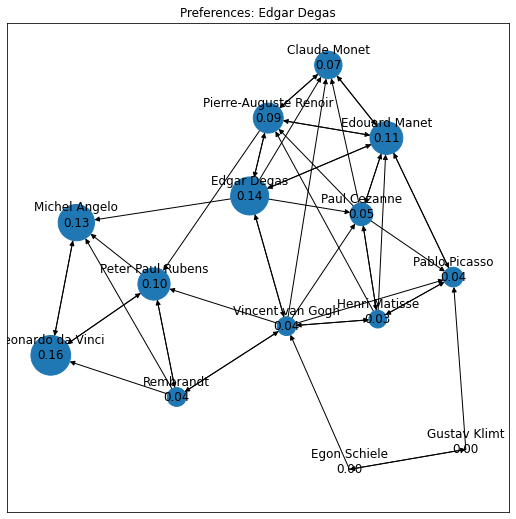

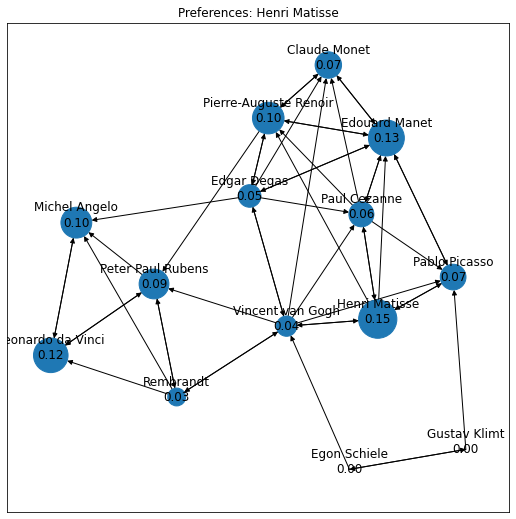

In [ ]:
cases = [
    ['Pablo Picasso', 'Edgar Degas'], 
    ['Edgar Degas'], 
    ['Henri Matisse']
]
for pref in cases:
    pr = personalized_pr(G, alpha=0.9, pref=pref, k=100)
    plot_painters(G, pr)
    pref = ', '.join(pref)
    plt.title(f'Preferences: {pref}')

Low transionion probability forces to teleport into prefferential nodes and vice versa, so we can adjust the power of preferences changing transition probability.

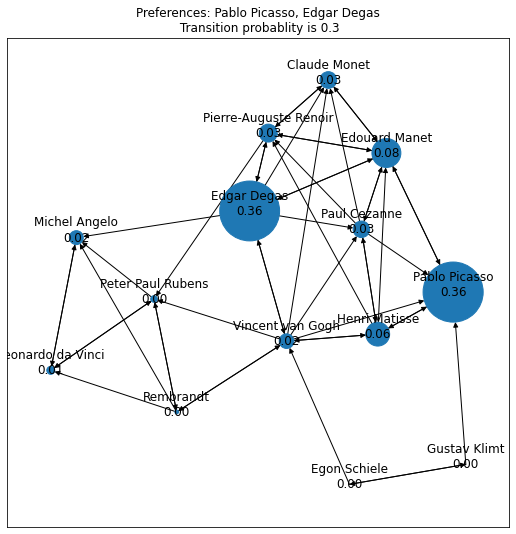

In [ ]:
pref = ['Pablo Picasso', 'Edgar Degas']
alpha = 0.3
pr = personalized_pr(G, alpha=alpha, pref=pref, k=100)
plot_painters(G, pr)
pref = ', '.join(pref)
plt.title(f'Preferences: {pref}\n Transition probablity is {alpha}');

### Task 3. PageRank visualization (3 points)

In this task we will visualize some properties of PageRank. First, we draw a plot where every line represents a PageRank of a node with respect to alpha while the number of iterations is fixed.

Write a function `rank_matrix_by_alpha` that takes a graph `G`, np.array of `alphas`, number of iterations `k` and returns a matrix of PageRank scores where alphas are rows and nodes are columns.

In [ ]:
def rank_matrix_by_alpha(G, alphas, k):
    return np.vstack([page_rank(G, al, k) for al in alphas])

In [ ]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/painters_graph.gml'
open('painters_graph.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('painters_graph.gml')
G = nx.convert_node_labels_to_integers(G)
alpha_space = np.linspace(0.1, 0.95, 100)
ranks = rank_matrix_by_alpha(G, alpha_space, 100)
assert ranks.shape == (100, 14)
assert ranks[-1, 0] < ranks[0, 0] < 0.08
assert ranks[0, 7] > ranks[-1, 7] > 0.02

Now write a function `node_color` that takes a `node` and np.array with PageRank scores `rank`. The length of `rank` is the number of nodes and `rank[node]` is a score of a node. Also here are two colors:
* `start_rgb` — a np.array of RGB color [0-1, 0-1, 0-1]
* `end_rgb` — a np.array of RGB color [0-1, 0-1, 0-1]

The function is a linear mapping from an _index_ (not score) of a node in sorted PageRank to a RGB color, that is the lowest index is a start color and the largest index is an end color. 

_For example, if a start color is [1, 1, 1], end color is [0, 0, 0] and PageRank of nodes are_
* 0: 0.1
* 1: 0.2
* 2: 0.7

_then the mapping of node 1 will be [0.5, 0.5, 0.5]._

The function returns a np.array of RGB color.

In [ ]:
def node_color(node, rank, start_rgb, end_rgb):
    sorted_rank = sorted(rank)
    index = sorted_rank.index(rank[node])
    return start_rgb + (end_rgb - start_rgb) * index / (len(rank) - 1)

In [ ]:
rank = np.array([0.1, 0.2, 0.7])
start_rgb, end_rgb = np.array([1, 1, 1]), np.array([0, 0, 0])
temp_rgb = node_color(1, rank, start_rgb, end_rgb)
assert temp_rgb.shape == (3,)
assert 0 <= temp_rgb.sum() <= 3
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 0.5
temp_rgb = node_color(0, rank, start_rgb, end_rgb)
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 1
temp_rgb = node_color(2, rank, start_rgb, end_rgb)
assert temp_rgb[0] == temp_rgb[1] == temp_rgb[2] == 0
start_rgb = np.array([231, 76, 60]) / 255
end_rgb = np.array([46, 204, 113 ]) / 255
assert round(node_color(0, ranks[-1], start_rgb, end_rgb).sum(), 4) == 1.432
assert round(node_color(1, ranks[-1], start_rgb, end_rgb).sum(), 4) == 1.4271

Let us draw PageRank of nodes by alpha. Node with the lowest PageRank will be red, the largest — green, and others will spread between them.

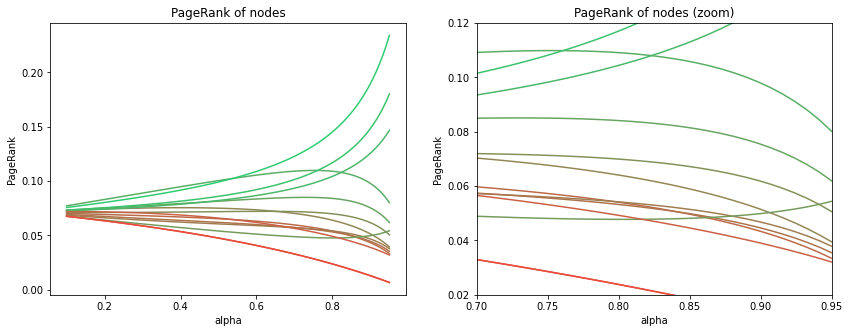

In [ ]:
plt.figure(figsize=(14, 5))

cases = [[1, None, None, None, None, 'PageRank of nodes'], 
         [2, 0.7, 0.95, 0.02, 0.12, 'PageRank of nodes (zoom)']]

for i, x_min, x_max, y_min, y_max, t in cases:
    plt.subplot(1, 2, i)
    for idx, node in enumerate(G.nodes):
        plt.plot(
            alpha_space, 
            ranks[:, idx], 
            color=node_color(idx, ranks[-1], start_rgb, end_rgb)
        )
    plt.xlabel('alpha')
    plt.ylabel('PageRank')
    plt.title(t)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

We can observe that reds are going down, greens going up, but some intermediate nodes change the direction near alpha 0.7. Next, let us draw a similar plot — PageRank of nodes with respect to number of iterations while alpha is fixed.

Write a function `rank_matrix_by_alpha` that takes a graph `G`, `alpha`, number of iterations `k` and returns a matrix of PageRank scores where iterations are rows and nodes are columns. Iterations are 1, 2, ..., `k`.

In [ ]:
def rank_matrix_by_number(G, alpha, k):
    return np.vstack([page_rank(G, alpha, i) for i in range(1, k + 1)])

In [ ]:
ranks = rank_matrix_by_number(G, 0.9, 15)
ranks.shape == (16, 34)
assert 0.04 < ranks[:, 0].min() < ranks[:, 0].max() < 0.09
assert 0.03 < ranks[:, 7].min() < ranks[:, 7].max() < 0.06

Let us draw dependencies between PageRank and number of iterations.

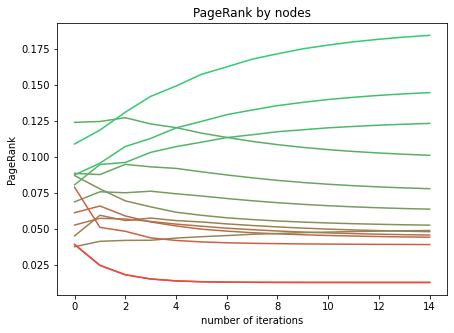

In [ ]:
plt.figure(figsize=(7, 5))
for idx, node in enumerate(G.nodes):
    plt.plot(
        ranks[:, idx], 
        color=node_color(idx, ranks[-1], start_rgb, end_rgb)
    )
plt.xlabel('number of iterations')
plt.ylabel('PageRank')
plt.title('PageRank by nodes')
plt.show()

Next, let us see another visualization of PageRank dynamics. Here are nodes on x axis and PageRank on y axis with log scale.

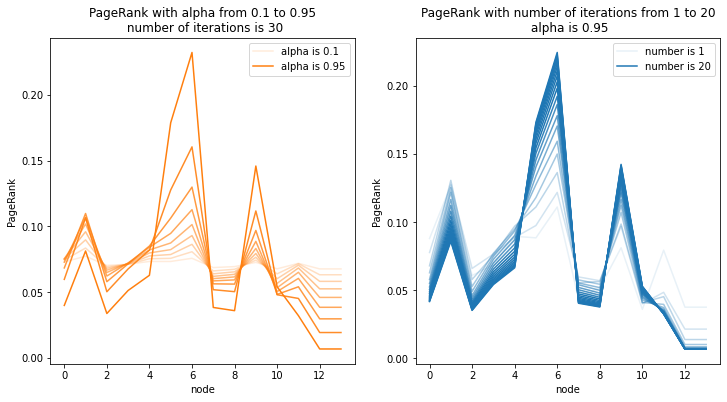

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
artists = []
for alpha in np.linspace(0.1, 0.95, 9):
    artists.append(plt.plot(page_rank(G, alpha, 30), alpha=alpha+0.05, c='tab:orange')[0])
plt.title('PageRank with alpha from 0.1 to 0.95\n number of iterations is 30')
plt.xlabel('node')
plt.ylabel('PageRank')
plt.legend([artists[0], artists[-1]], ['alpha is 0.1', 'alpha is 0.95'])

plt.subplot(1, 2, 2)
artists = []
for i in np.arange(1, 20):
    artists.append(plt.plot(page_rank(G, 0.95, i), alpha=min(i*0.1, 1), c='tab:blue')[0])
plt.title('PageRank with number of iterations from 1 to 20\n alpha is 0.95')
plt.xlabel('node')
plt.ylabel('PageRank')
plt.legend([artists[0], artists[-1]], ['number is 1', 'number is 20'])

plt.show()

Finally, let us check that PageRank converges to degree centrality in an undirected graph.

Write a function `rank_degree_scatter` that takes a graph `G`, `alpha` and number of iterations `k` and returns a scatter plot (`matplotlib.collections.PathCollection` object). The function draws a scatter plot with PageRank on x axis and degree centrality on y axis.

In [ ]:
def rank_degree_scatter(G, alpha, k):
    x = page_rank(G, alpha, k)
    y = list(nx.centrality.degree_centrality(G).values())
    return plt.scatter(x, y)

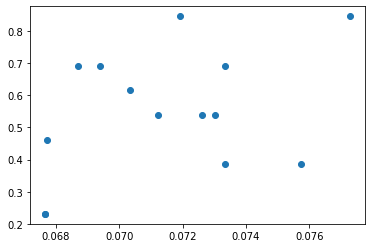

In [ ]:
scatter = rank_degree_scatter(G, 0.1, 30)
sc_data = scatter.get_offsets().data
assert sc_data.shape == (14, 2)
assert 0.35 < np.corrcoef(sc_data[:, 0], sc_data[:, 1])[0, 1] < 0.42
assert 0.05 < sc_data[:, 0].min() < sc_data[:, 0].max() < 0.08
assert 0.01 < sc_data[:, 1].min() < sc_data[:, 1].max() < 0.9

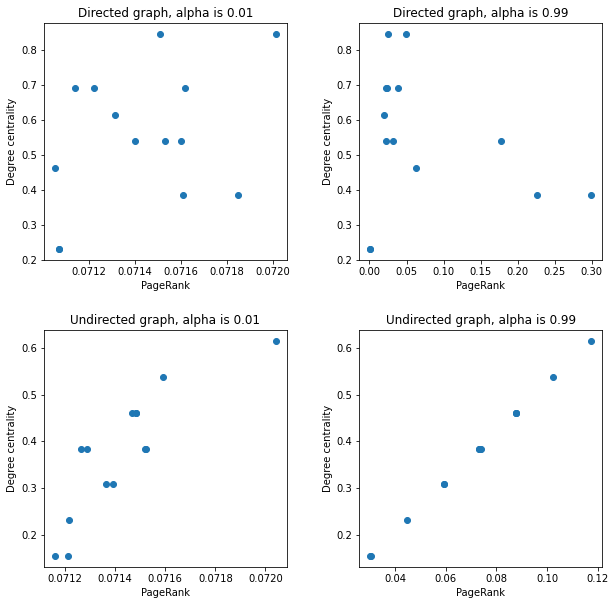

In [ ]:
plt.figure(figsize=(10, 10))

cases = [
    [0.01, G, 'Directed'],
    [0.99, G, 'Directed'],
    [0.01, nx.Graph(G), 'Undirected'],
    [0.99, nx.Graph(G), 'Undirected'],
]

for i, (alpha, graph, graph_type) in enumerate(cases):
    plt.subplot(2, 2, i+1)
    scatter = rank_degree_scatter(graph, alpha, 100)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.xlabel('PageRank')
    plt.ylabel('Degree centrality')
    plt.title(f'{graph_type} graph, alpha is {alpha}')
plt.show()

### Task 4. HITS visualization (2 points)

In this task we will try to find authorities and hubs in political blogs and visualize them. The data is provided from [Political blogosphere Feb. 2005](http://vlado.fmf.uni-lj.si/pub/networks/data/mix/mixed.htm) dataset.

The graph contains parallel edges, but HITS algorithm only works without parallel edges. The simplest way to drop parallel edges is to convert a directed multigraph (`nx.MultiDiGraph`) into a directed graph (`nx.DiGraph`).

Write a function `hits_polblogs` that takes a path to a gml file with data and returns a tuple with a graph and two dictionaries of the form
* `{node: value}`

The first dictionary is hub scores, the second one is authority scores. That is, a full output is `(G, hub, auth)`. Apply `nx.hits` to calculate hub and authority scores.

In [ ]:
def hits_polblogs(filename):
    G = nx.readwrite.gml.read_gml(filename)
    G = nx.DiGraph(G)
    hub, auth = nx.hits(G)
    return G, hub, auth

In [ ]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/polblogs.gml'
open('polblogs.gml', 'wb').write(requests.get(url).content)
G, hub, auth = hits_polblogs('polblogs.gml')
assert type(G) == nx.DiGraph
assert len(hub.values()) == len(auth.values()) == 1490
assert round(max(hub.values()), 4) == 0.0069
assert round(max(auth.values()), 4) == 0.015

In [ ]:
G.number_of_nodes()

1490

In [ ]:
G.number_of_edges()

19025

There are many edges and nodes and it makes hard to draw the whole graph. Then, let us draw a scatter plot with hub and authority scores.

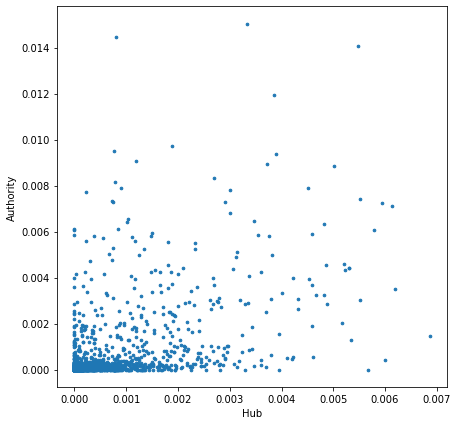

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(hub.values(), auth.values(), s=7)
plt.xlabel('Hub')
plt.ylabel('Authority')
plt.show()

Next, draw a graph with 14 nodes: top 7 authorities and top 7 hubs. Hubs will be on the left, authorities will be on the right.

Write a function `hits_visualization` that takes a graph `G`, hub, authority dictionaries, the number of top nodes and returns a dictionary with keys:
* `h_top` — np.array of top nodes by hub score
* `a_top` — np.array of top nodes by authority score
* `subG` — subgraph of `G` with top nodes only
* `h_vals` — np.array with hub scores (in initial graph) of top nodes that ordered by `subG.nodes` view 
* `a_vals` — the same for authority score
* `pos` — dictionary with keys are nodes and values are x-y positions of the form

`{node: [x, y]}` where 
* x equals to 0 if it is a hub and 1 if it is a authority
* y equals to an index of top array

That is, x could be 0 or 1 and y could be 0, 1, ..., 6.

In [ ]:
np.array(['ddd','ddddd'])

array(['ddd', 'ddddd'], dtype='<U5')

In [ ]:
lh = list(hub.items())
lh.sort(key=lambda x: x[1], reverse=True)
lh[:10]

[('politicalstrategy.org', 0.006860032845402865),
 ('madkane.com/notable.html', 0.006198130021781299),
 ('liberaloasis.com', 0.00613468960204917),
 ('stagefour.typepad.com/commonprejudice', 0.005990729097991839),
 ('bodyandsoul.typepad.com', 0.0059396266914565985),
 ('corrente.blogspot.com', 0.00578351363156203),
 ('atrios.blogspot.com/ ', 0.005668066677561788),
 ('newleftblogs.blogspot.com', 0.00552512093383479),
 ('tbogg.blogspot.com', 0.005519058143101522),
 ('atrios.blogspot.com', 0.005484909242414887)]

In [ ]:
def hits_visualization(G, hub, auth, top):
    lh = list(hub.items())
    lh.sort(key=lambda x: x[1], reverse=True)
    lh = lh[:top]

    la = list(auth.items())
    la.sort(key=lambda x: x[1], reverse=True)
    la = la[:top]

    d = {}

    d['h_top'] = np.array([x[0] for x in lh])
    d['a_top'] = np.array([x[0] for x in la])


    all_nodes = [x[0] for x in lh] + [x[0] for x in la]
    d['h_vals'] = np.array([hub[x] for x in all_nodes])
    d['a_vals'] = np.array([auth[x] for x in all_nodes])


    d['subG'] = nx.subgraph(G, all_nodes)

    pos = {}
    for i in range(len(all_nodes)):
      z = 0
      if all_nodes[i] in d['a_top']:
        z = 1
      pos[all_nodes[i]] = [z, i - z * top]

    d['pos'] = pos

    return d





In [ ]:
vi = hits_visualization(G, hub, auth, 7)
h_top, a_top = vi['h_top'], vi['a_top']
h_vals, a_vals = vi['h_vals'], vi['a_vals']
subG, pos = vi['subG'], vi['pos']
assert h_top.shape[0] == a_top.shape[0] == int(len(subG) / 2) == 7
assert 'politicalstrategy.org' == h_top[0]
assert 'talkingpointsmemo.com' in a_top
assert h_vals.shape == a_vals.shape == (14,)
assert h_vals.max() < 0.0069
assert 0 <= a_vals.min()
assert pos['atrios.blogspot.com'] == [1, 2]
assert pos['juancole.com'] == [1, 5]

Networkx allows to draw nodes, edges, labels separately. In this case, we need to fix a layout and then draw a graph by layers. Let us draw a graph via `nx.draw_networkx`, then draw right labels and then draw left labels via `nx.draw_networkx_labels`. Also we will crop labels with more than 15 symbols to fit on the screen.

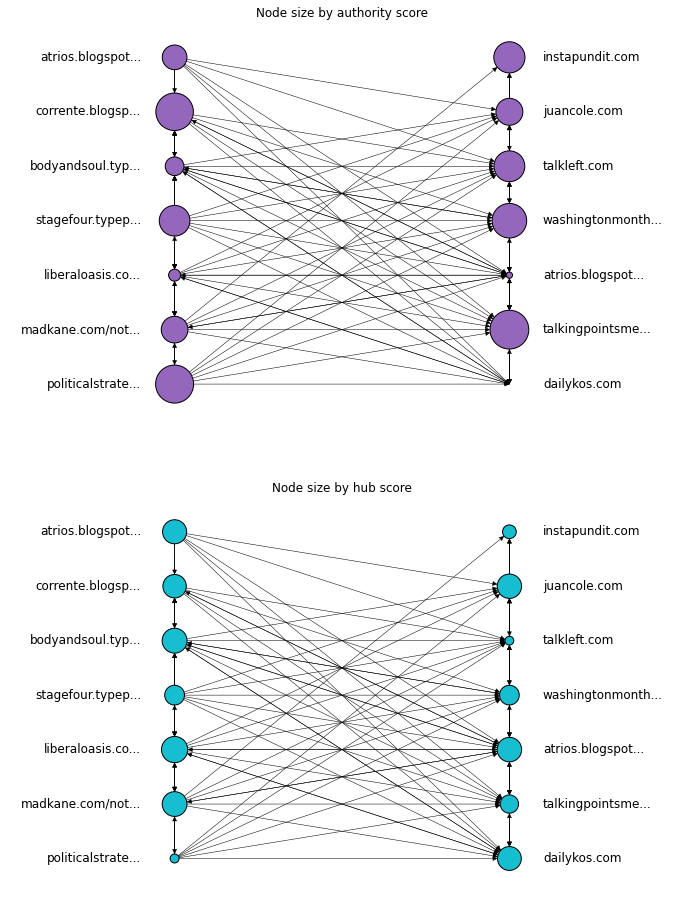

In [ ]:
plt.figure(figsize=(12, 8*2))

h_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in h_top}
a_labels = {i:i[:15] if len(i)<=15 else i[:15] + '...' for i in a_top}
a_pos = {node:(pos[node][0] + 0.1, pos[node][1]) for node in pos}
h_pos = {node:(pos[node][0] - 0.1, pos[node][1]) for node in pos}

cases = [[1, 'tab:purple', a_vals, 'Node size by authority score'], 
         [2, 'tab:cyan', h_vals, 'Node size by hub score']]
for i, color, vals, t in cases:
    plt.subplot(2, 1, i)
    plt.gca().axis('off')
    nx.draw_networkx(
        subG,
        pos,
        width=0.5,
        with_labels=False,
        edgecolors='black',
        node_size=vals*1e5,
        node_color=color
    )
    nx.draw_networkx_labels(
        subG,
        pos=a_pos,
        labels=a_labels,
        horizontalalignment='left'
    )
    nx.draw_networkx_labels(
        subG,
        pos=h_pos,
        labels=h_labels,
        horizontalalignment='right'
    )

    plt.xlim(-0.5, 1.5)
    plt.title(t)

### Task 5. Node similarity (0 points)

In this section we will look at how nodes can be similar to each other. We will consider the movie co-watch dataset. The dataset is builded based on the MovieLens-100k data. The films have links between when one user gives them the highest rate and watch both.

In [ ]:
url = "https://raw.githubusercontent.com/netspractice/network-science/main/datasets/movies.gml"
open('movie-cowatch.gml', 'wb').write(requests.get(url).content)
G = nx.read_gml('movie-cowatch.gml')

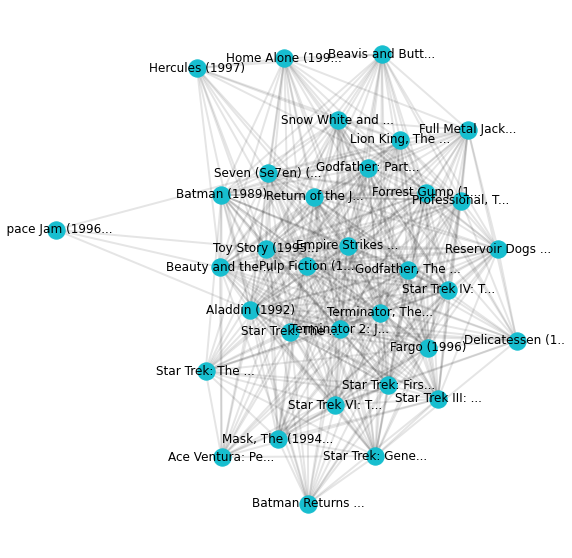

In [ ]:
labs = nx.get_node_attributes(G, "movieName")
labs = {i:labs[i][:15] if len(labs[i])<=15 else labs[i][:15] + '...' for i in labs}
plt.figure(figsize=(10, 10))
plt.gca().axis('off')

pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color='tab:cyan'
)
nx.draw_networkx_edges(
    G,
    pos,
    width=2,
    alpha=0.1,
)
nx.draw_networkx_labels(
    G,
    pos,
    labels=labs
)
plt.show()

Write a function `sim_matrices` that takes a graph and returns a tuple with similarity matrices:
* Adjacency matrix
* Pearson correlation
* Jaccard similarity
* Cosine similarity

Look at networkx, sklearn, numpy.

In [ ]:
import sklearn
def sim_matrices(G):
    res = []
    A = nx.to_numpy_array(G)
    res.append(A)
    res.append(np.corrcoef(A))
    J = np.zeros((len(G), len(G)))
    cos_sim = np.zeros((len(G), len(G)))
    mapping = {n: i for i, n in enumerate(G.nodes)}
    for i, j, jc in nx.jaccard_coefficient(G):
        J[mapping[i]][mapping[j]] = J[mapping[j]][mapping[i]] = jc
    for i in range(len(G)):
        for j in range(len(G)):
            cos_sim[i, j] = A[i] @ A[j] / np.linalg.norm(A[i]) / np.linalg.norm(A[j])
    res.append(J)
    res.append(cos_sim)
    return res

In [ ]:
A, corr, J, cos = sim_matrices(G)
assert A.shape == corr.shape == J.shape == cos.shape == (34,34)
assert A[0].sum() == 33
assert corr[0].sum().round(4) == -2.5541
assert J[1].sum().round(4) == 1.7667
assert cos[0].sum().round(4) == 28.4601

Let us draw heatmaps of these similarities.

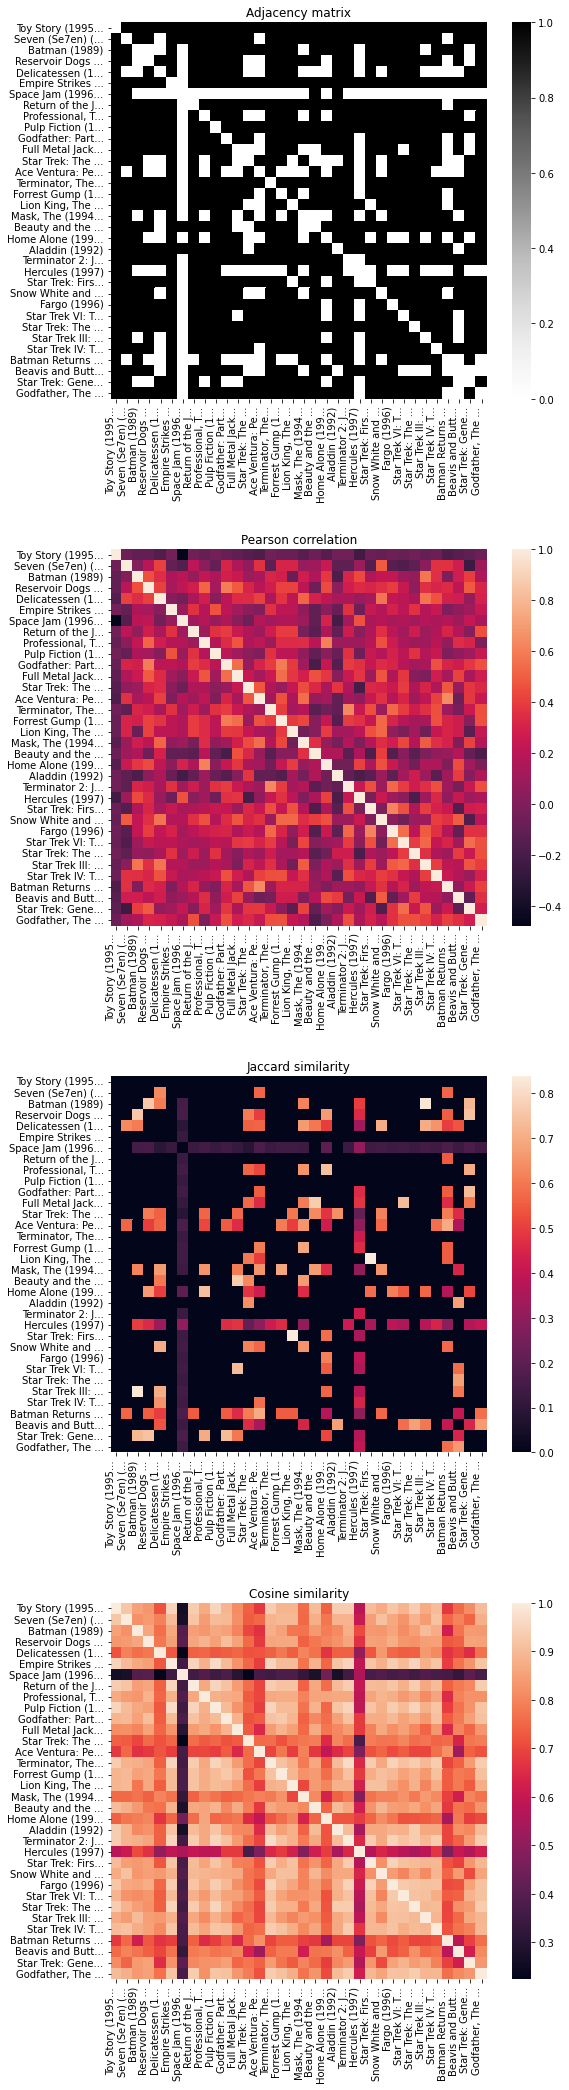

In [ ]:
fig = plt.figure(figsize=(9, 9*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, corr, None, 'Pearson correlation'], 
         [3, J, None, 'Jaccard similarity'], 
         [4, cos, None, 'Cosine similarity'], ]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True,
        yticklabels=[labs.get(i) for i in G.nodes])
    hmap.set_xticklabels(
        labels=[labs.get(i) for i in G.nodes], 
        horizontalalignment='right')
    plt.title(t)

### Task 6. Cuthill-McKee reordering (3 points)

Without special preprocess procedures an adjacency matrix can look very noisy and hide network's structure. There are some procedures of node reordering that provides a better view of the network's adjacency matrix. Reverse Cuthill-McKee finds permutation of the nodes that minimizes the bandwidth of the matrix, which is calculated as

$$ \theta = \max_{a_{ij} > 0}|i-j|$$

Unformally, this algorithm puts some mass on the diagonal of adjacency matrix. 

Write a function `cm_order` that takes a graph and returns a np.array with a permutation of the form $[i_1, i_2, \dots, i_n]$ where $i_1$ is an index of the first row and the first column.

Apply `scipy.sparse.csgraph.reverse_cuthill_mckee` or `nx.utils.reverse_cuthill_mckee_ordering`.

In [ ]:
def cm_order(G):
    A = nx.to_scipy_sparse_matrix(G)
    return reverse_cuthill_mckee(A)

In [ ]:
order = cm_order(G)
assert order.shape == (34,)
assert order[4:6].sum() < order[:3].sum() < order[4:7].sum()

Let us draw the heatmaps with a default and changed order side-by-side. A default order will be on the left, a changed order — on the right.

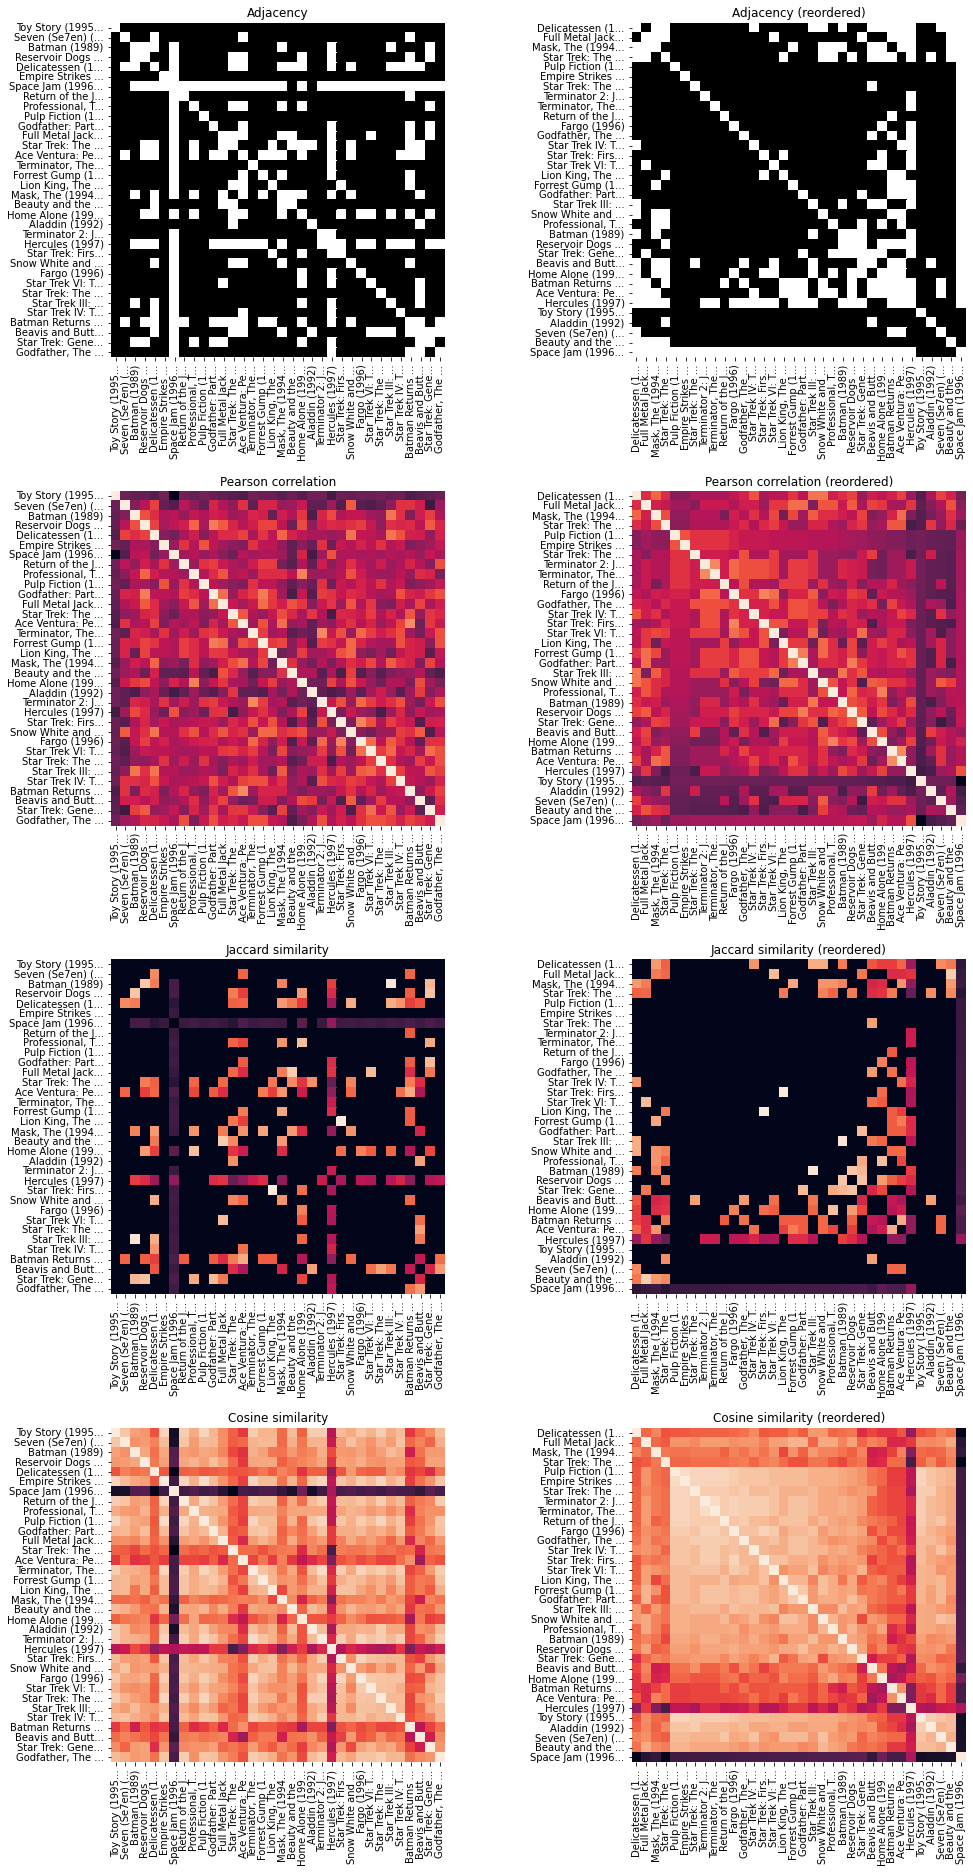

In [ ]:
fig = plt.figure(figsize=(16, 16*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(34)],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [3, corr, None, 'Pearson correlation', range(34)], 
         [4, corr, None, 'Pearson correlation (reordered)', order], 
         [5, J, None, 'Jaccard similarity', range(34)], 
         [6, J, None, 'Jaccard similarity (reordered)', order], 
         [7, cos, None, 'Cosine similarity', range(34)], 
         [8, cos, None, 'Cosine similarity (reordered)', order]]

newLabs = np.array([labs.get(i) for i in G.nodes])

for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True,
        yticklabels=newLabs[o])
    hmap.set_xticklabels(
        labels=newLabs[o], 
        rotation=90)
    plt.title(t)

We can observe that the right-hand heatmaps look smoother, and we can detect dense regions on them.

### Task 7. Assortative mixing visualization (2 points)

In this task, we look at the same dataset. One can find that graph have attribute `Genre`. Let us draw assortative mixing of a `Genre` attribute. How often persons from one house kills persons from another?

Write a function `genre_mixing` that takes a graph `G` and returns tuple with a matrix of assortative mixing `nx.attribute_mixing_matrix` by a `Genre` attribute and a dictionary with mapping of the form
* `{genre: index in the matrix}`

In [ ]:
def genre_mixing(G):
    li = list(set(nx.get_node_attributes(G, 'Genre').values()))
    mapping = {li[i]:i for i in range(len(li))}
    return nx.attribute_mixing_matrix(G, attribute='Genre', mapping=mapping), mapping

In [ ]:
mixing, mapping = genre_mixing(G)
assert mixing.shape == (8, 8)
assert mixing.max() < 0.08
assert mixing.min() == 0
assert mapping.get("Comedy") is not None

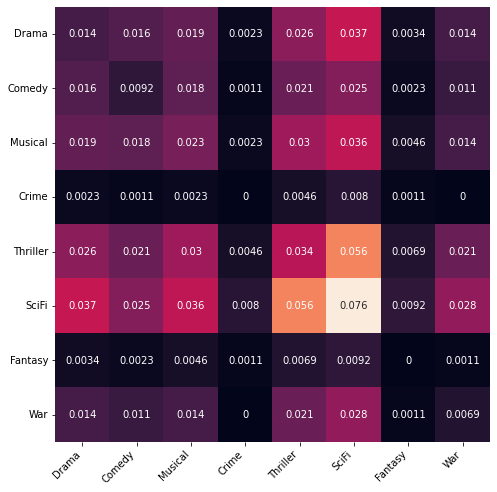

In [ ]:
fig = plt.figure(figsize=(8, 8))
hmap = sns.heatmap(
    mixing,
    cbar=False,
    annot=True,
    square=True)
hmap.set_xticklabels(
    labels=[m for m in mapping], 
    rotation=45, 
    horizontalalignment='right')
hmap.set_yticklabels(
    labels=[m for m in mapping], 
    rotation=0)
plt.show()